In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.read_csv?


In [5]:
root_path = 'gdrive/My Drive/'
df = pd.read_csv(
    '/content/drive/MyDrive/twitter.zip', compression='zip', 
    encoding_errors='ignore', on_bad_lines='skip',
  names=["id", "date", "query", "user", "content"],
  header=None, nrows=1000
)

In [6]:
df.head()

,id,date,query,user,content
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1000


Preprocessing

In [8]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras_preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 15

In [9]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[0,4]
text

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [10]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['switchfoot',
 'http',
 'twitpic',
 'com',
 '2y1zl',
 'awww',
 "that's",
 'a',
 'bummer',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 'd']

In [11]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df.iterrows():
    sentence_tokens.append(text_to_word_sequence(row["content"]))

In [12]:
sentence_tokens[:2]

[['switchfoot',
  'http',
  'twitpic',
  'com',
  '2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to',
  'do',
  'it',
  'd'],
 ['is',
  'upset',
  'that',
  'he',
  "can't",
  'update',
  'his',
  'facebook',
  'by',
  'texting',
  'it',
  'and',
  'might',
  'cry',
  'as',
  'a',
  'result',
  'school',
  'today',
  'also',
  'blah']]

In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
text_sequences

[['switchfoot',
  'http',
  'twitpic',
  'com',
  '2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of'],
 ['http',
  'twitpic',
  'com',
  '2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third'],
 ['twitpic',
  'com',
  '2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day'],
 ['com',
  '2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to'],
 ['2y1zl',
  'awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to',
  'do'],
 ['awww',
  "that's",
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to',
  'do',
  'it']]

Crear vectores

In [15]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
sequences

[[19, 17, 15, 13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [17, 15, 13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 [15, 13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14],
 [13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16],
 [11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]]

In [17]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

6


In [18]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

20


In [19]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'awww': 1, "that's": 2, 'a': 3, 'bummer': 4, 'you': 5, 'shoulda': 6, 'got': 7, 'david': 8, 'carr': 9, 'of': 10, '2y1zl': 11, 'third': 12, 'com': 13, 'day': 14, 'twitpic': 15, 'to': 16, 'http': 17, 'do': 18, 'switchfoot': 19, 'it': 20}


In [20]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'com': 4, 'got': 6, 'a': 6, 'carr': 6, 'http': 2, 'switchfoot': 1, '2y1zl': 5, 'you': 6, 'shoulda': 6, 'david': 6, 'bummer': 6, 'awww': 6, 'of': 6, 'twitpic': 3, "that's": 6, 'third': 5, 'day': 4, 'to': 3, 'do': 2, 'it': 1})


Preprocesamiento completo

In [21]:
df.loc[:15,"content"]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
0    is upset that he can't update his Facebook by ...
0    @Kenichan I dived many times for the ball. Man...
0      my whole body feels itchy and like its on fire 
0    @nationwideclass no, it's not behaving at all....
                           ...                        
0    @dkoenigs thanks man.  I'm so very grateful.  ...
0    @t_wolfe  i miss u too. i'm totally comin back...
0    @sniffinglue ohhh. I love it. ps I'm sad we di...
0            And somehow I still end up in this place 
0           @kisluvkis oh that is very sad, poor boy. 
Name: content, Length: 1000, dtype: object

In [22]:
# Concatenamos todos los rows en un solo valor
corpus = df["content"]
corpus

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
0    is upset that he can't update his Facebook by ...
0    @Kenichan I dived many times for the ball. Man...
0      my whole body feels itchy and like its on fire 
0    @nationwideclass no, it's not behaving at all....
                           ...                        
0    @dkoenigs thanks man.  I'm so very grateful.  ...
0    @t_wolfe  i miss u too. i'm totally comin back...
0    @sniffinglue ohhh. I love it. ps I'm sad we di...
0            And somehow I still end up in this place 
0           @kisluvkis oh that is very sad, poor boy. 
Name: content, Length: 1000, dtype: object

In [23]:
corpus = "\n".join(corpus.tolist())

In [24]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['switchfoot',
 'http',
 'twitpic',
 'com',
 '2y1zl',
 'awww',
 "that's",
 'a',
 'bummer',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it']

In [25]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 13786


In [26]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [27]:
#text_sequences[:20]

In [28]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[3477, 70, 191, 79, 3476, 300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12],
 [70, 191, 79, 3476, 300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154],
 [191, 79, 3476, 300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44],
 [79, 3476, 300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2],
 [3476, 300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51],
 [300, 190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9],
 [190, 5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301],
 [5, 3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7],
 [3474, 11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258],
 [11, 3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258, 16],
 [3473, 50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258, 16, 87],
 [50, 523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258, 16, 87, 57],
 [523, 3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258, 16, 87, 57, 406],
 [3472, 12, 1154, 44, 2, 51, 9, 301, 7, 258, 16, 87, 57, 406, 193],
 

In [29]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 13771


Input y target

In [30]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [31]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [32]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [33]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(13771, 14)
(13771,)


In [34]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'to',
 3: 'the',
 4: 'my',
 5: 'a',
 6: 'and',
 7: 'is',
 8: 'in',
 9: 'it',
 10: 'for',
 11: 'you',
 12: 'of',
 13: 'me',
 14: 'so',
 15: "i'm",
 16: 'that',
 17: 'but',
 18: 'have',
 19: 'was',
 20: 'not',
 21: 'on',
 22: 'this',
 23: 'at',
 24: 'just',
 25: 'no',
 26: 'with',
 27: 'out',
 28: 'get',
 29: 'too',
 30: 'all',
 31: 'now',
 32: 'be',
 33: 'sad',
 34: 'like',
 35: "don't",
 36: 'up',
 37: 'work',
 38: "it's",
 39: 'quot',
 40: 'time',
 41: 'sleep',
 42: 'still',
 43: 'go',
 44: 'day',
 45: 'going',
 46: 'really',
 47: 'one',
 48: 'back',
 49: 'know',
 50: 'got',
 51: 'do',
 52: 'today',
 53: 'its',
 54: 'miss',
 55: 'has',
 56: 'from',
 57: "can't",
 58: 'how',
 59: 'im',
 60: 'are',
 61: 'am',
 62: 'much',
 63: 'good',
 64: 'they',
 65: 'about',
 66: 'when',
 67: 'want',
 68: 'an',
 69: 'some',
 70: 'http',
 71: 'night',
 72: 'what',
 73: 'why',
 74: 'sorry',
 75: 'oh',
 76: 'see',
 77: 'tomorrow',
 78: 'your',
 79: 'com',
 80: 'had',
 81: 'think',
 82: 'fee

In [35]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3477

In [36]:
tok

In [37]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(13771, 3477)

Training

In [38]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

14

In [39]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3477

In [47]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32)) # La última capa LSTM no lleva return_sequences
model.add(Dense(16, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 5)             17390     
                                                                 
 lstm_2 (LSTM)               (None, 14, 32)            4864      
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3477)              59109     
                                                                 
Total params: 90,211
Trainable params: 90,211
Non-trai

In [48]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
345/345 [==============================] - 13s 26ms/step - loss: 7.1402 - accuracy: 0.0392 - val_loss: 7.0994 - val_accuracy: 0.0417
Epoch 2/50
345/345 [==============================] - 8s 23ms/step - loss: 6.7139 - accuracy: 0.0431 - val_loss: 7.2417 - val_accuracy: 0.0417
Epoch 3/50
345/345 [==============================] - 8s 23ms/step - loss: 6.6570 - accuracy: 0.0431 - val_loss: 7.3191 - val_accuracy: 0.0417
Epoch 4/50
345/345 [==============================] - 8s 23ms/step - loss: 6.5790 - accuracy: 0.0431 - val_loss: 7.3091 - val_accuracy: 0.0417
Epoch 5/50
345/345 [==============================] - 8s 23ms/step - loss: 6.5236 - accuracy: 0.0431 - val_loss: 7.3896 - val_accuracy: 0.0417
Epoch 6/50
345/345 [==============================] - 8s 23ms/step - loss: 6.4681 - accuracy: 0.0431 - val_loss: 7.5494 - val_accuracy: 0.0417
Epoch 7/50
345/345 [==============================] - 8s 23ms/step - loss: 6.4137 - accuracy: 0.0431 - val_loss: 7.5161 - val_accuracy: 0.041

Gráfico

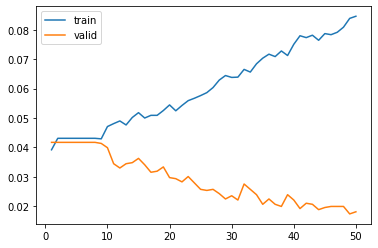

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Predicción próxima palabra

In [45]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [46]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=14, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.
